_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: Stephan Amann, Hannah Blaurock, David Kleindiek

# Coding Lab 8



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rc("savefig", dpi=72)
sns.set_style("whitegrid")
%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-06-26 22:18:05CEST

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.24.0

sklearn: 1.4.2

seaborn   : 0.13.2
scipy     : 1.13.0
matplotlib: 3.8.4
numpy     : 1.26.4

Watermark: 2.4.3



# Task 1: Implement entropy estimators


*Grading: 5 pts (basic) + 1 pts (advanced) + 3 pts (bonus)*

## General framework

Entropy is defined as 

$$
H[p] = -\sum_x p_x \log p_x
$$

where $p_x = p(x=X)$. Here we assume that $X$ is a discrete random variable and that there are finitely many states $K$ that $X$ can take.

We are interested in the entropy of discrete random variables, because of its relationship with mutual information:

$$
I[X|Y] = H[X] - H[X|Y]
$$

If we can estimate the entropy well, we can estimate the mutual information well. An application in neuroscience would be estimating the mutual information between a spike train modeled as a sequence of $1$ s and $0$ s (e.g. $(0,1,0,1,1)$) and a discrete set of stimuli.

Note that a multivariate binary distribution modeling a spike train can always be mapped to a discrete univariate distribution, $\mathbb{Z}_2 \longrightarrow \mathbb{Z_+}$, by interpreting each binary state $z \in \mathbb{Z}_2$ as its corresponding binary number and computing $f(z) = \sum_i 2^{i} z_i$.

As discussed in the lecture, the problem is that one always underestimates the true entropy of a distribution from samples. In this exercise you are meant to implement different estimators for discrete entropy and evaluate them on different discrete distributions:

* Uniform distribution: $p(x=X) = \frac{1}{K}$

* "Zipf's law"- distribution: $p(x=X) = \frac{1}{Z x} $, where $Z = \sum_k 1/k$

There is a really good series of blog posts about discrete entropy estimation to be found [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-1.html), [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-2.html) and [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-3.html). 

Make sure you use binary logarithms throughout.


## Implementation of the estimators

Implement the

* maximum likelihood estimator (1 pt)
* miller-maddow corrected estimator (1 pt)
* jack-knife corrected estimator (2 pt)
* coverage adjusted estimator (1 pt).

When implementing the jack-knife estimator, you may want to restrict the amount of resampling for performance reasons e.g. to 1000, even if more samples are available. By definition, $0\log0=0$. Adapt the interfaces as needed for your implementation.

In addition, implement or use one of the following more advanced estimators (1+3 pts, extra points if you use your own implementation):

* [JVHW estimator](https://arxiv.org/abs/1406.6956) with code on [github](https://github.com/EEthinker/JVHW_Entropy_Estimators/tree/master/Python)
* [Unseen estimator](http://papers.nips.cc/paper/5170-estimating-the-unseen-improved-estimators-for-entropy-and-other-properties) (includes Matlab code in Supplementary)
* [Best Upper Bounds estimator](http://www.mitpressjournals.org/doi/abs/10.1162/089976603321780272) (Matlab code available on Ilias)

For this part, you are allowed to use an existing implementation as well.


## Basic
*Grading: 5 pts*

### MLE

*Grading: 1 pts*

$H_{ML}= -\sum_{x}\hat{p}(x)log(\hat{p}(x))$

In [ ]:
def entropy_mle(phat):
    """Maximum likelihood or plug-in estimator of discrete entropy

    Parameter
    ---------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    Return
    ------
    H: float
        Entropy estimate
    """
    # insert your code here (1 pt)
    phat = phat[phat > 0]  # avoid log(0)
    H = -np.sum(phat * np.log2(phat))

    return H

### Miller-Maddow corrected

*Grading: 1 pts*

$H_{MM}=H_{ML}+\frac{\hat{d}-1}{2n}$ 

$ \hat{d} = \#[\hat{p}(x)>0]$ 



In [ ]:
def entropy_mm(phat, n):
    """Miller-Maddow corrected estimator of discrete entropy

    Parameters
    ----------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    n:  int
        Number of samples


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (1 pt)
    dhat = np.sum(phat > 0)
    H = entropy_mle(phat) + (dhat - 1) / (2 * n)

    return H

### Jack-knife corrected

*Grading: 2 pts*

$\hat{H}_{JK} = N\hat{H}_{ML} - (N-1)\hat{H}_{ML}^{(.)}$ 

$\hat{H}_{ML}^{(.)} = <H_{ML}^{\lnot i}>$

In [ ]:
def entropy_jk(x, edges):
    """Jack-knife corrected estimator of discrete entropy

    Parameters
    ----------
    x: np.array, shape=(n_samples, )
        Samples

    edges: np.array, shape=(n_bins, )
        Histogram bin edges


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (2 pt)
    n = x.size
    phat = np.histogram(x, bins=edges)[0] / n

    # calculate the maximum likelihood entropy
    H_ML = entropy_mle(phat)

    H_JK = np.zeros(n)
    for i in range(n):
        # remove one sample
        phat_i = np.histogram(np.delete(x, i), bins=edges)[0] / (n - 1)
        # calculate entropy of the reduced sample
        H_JK[i] = entropy_mle(phat_i)

    # calculate the jack-knife corrected entropy
    H = n * H_ML - (n - 1) * np.mean(H_JK)

    return H

### Coverage-adjusted

*Grading: 1 pts*

$C = 1 - \frac{\# f_{i}=1}{N}$

$\hat{P}_{C}= \hat{P}\cdot C$ 

$H_{CA}= -\sum_{x}\frac{\hat{P_{C}}(x)log(\hat{P_{C}}(x))}{1-(1-\hat{P_{C}}(x))^N}$



In [ ]:
def entropy_cae(phat, n):
    """coverage-adjusted estimator of discrete entropy

    Parameters
    ----------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    n: int
        Number of samples.


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (1 pt)

    #  estimate the coverage probability C
    f1 = np.sum(phat == 1 / n)  # Number of singletons (frequency of 1)
    C = 1 - f1 / n

    phat_C = phat * C
    phat_C = phat_C[phat_C > 0]  # avoid log(0)

    H = -np.sum((phat_C * np.log2(phat_C)) / (1 - (1 - phat_C) ** n))

    return H

## Advanced
*Grading: 1 + 3 pts*

### JVHW
*Grading: 1 pts*

In [ ]:
# we use the implementation of the JVHW estimator from https://github.com/EEthinker/JVHW_Entropy_Estimators/blob/master/Python/est_entro.py
# TODO nachfragen ob wir das so verwenden dürfen
# TODO nachfragen ob wir auch das coefficient file reinladen dürfen
import scipy.io as sio

poly_entro = None


def entro_mat(x, n, g_coeff, c_1):
    # g_coeff = {g0, g1, g2, ..., g_K}, K: the order of best polynomial approximation,
    K = len(g_coeff) - 1
    thres = 4 * c_1 * np.log(n) / n
    T, X = np.meshgrid(thres, x)
    ratio = np.minimum(np.maximum(2 * X / T - 1, 0), 1)
    q = np.arange(K).reshape((1, 1, K))
    g = g_coeff.reshape((1, 1, K + 1))
    MLE = -X * np.log(X) + 1 / (2 * n)
    polyApp = np.sum(
        np.concatenate(
            (T[..., None], ((n * X)[..., None] - q) / (T[..., None] * (n - q))), axis=2
        ).cumprod(axis=2)
        * g,
        axis=2,
    ) - X * np.log(T)
    polyfail = np.isnan(polyApp) | np.isinf(polyApp)
    polyApp[polyfail] = MLE[polyfail]
    output = ratio * MLE + (1 - ratio) * polyApp
    return np.maximum(output, 0)


def est_entro_MLE(samp):
    """Maximum likelihood estimate of Shannon entropy (in bits) of the input
    sample

    This function returns a scalar MLE of the entropy of samp when samp is a
    vector, or returns a (row-) vector consisting of the MLE of the entropy
    of each column of samp when samp is a matrix.

    Input:
    ----- samp: a vector or matrix which can only contain integers. The input
                data type can be any interger classes such as uint8/int8/
                uint16/int16/uint32/int32/uint64/int64, or floating-point
                such as single/double.
    Output:
    ----- est: the entropy (in bits) of the input vector or that of each
               column of the input matrix. The output data type is double.
    """
    samp = formalize_sample(samp)
    [n, wid] = samp.shape
    n = float(n)

    f = fingerprint(samp)
    prob = np.arange(1, f.shape[0] + 1) / n
    prob_mat = -prob * np.log2(prob)
    return prob_mat.dot(f)


def formalize_sample(samp):
    samp = np.array(samp)
    if np.any(samp != np.fix(samp)):
        raise ValueError("Input sample must only contain integers.")
    if samp.ndim == 1 or samp.ndim == 2 and samp.shape[0] == 1:
        samp = samp.reshape((samp.size, 1))
    return samp


def fingerprint(samp):
    """A memory-efficient algorithm for computing fingerprint when wid is
    large, e.g., wid = 100
    """
    wid = samp.shape[1]

    d = np.r_[
        np.full((1, wid), True, dtype=bool),
        np.diff(np.sort(samp, axis=0), 1, 0) != 0,
        np.full((1, wid), True, dtype=bool),
    ]

    f_col = []
    f_max = 0

    for k in range(wid):
        a = np.diff(np.flatnonzero(d[:, k]))
        a_max = a.max()
        hist, _ = np.histogram(a, bins=a_max, range=(1, a_max + 1))
        f_col.append(hist)
        if a_max > f_max:
            f_max = a_max

    return np.array([np.r_[col, [0] * (f_max - len(col))] for col in f_col]).T


def entropy_jvhw(x):
    """JVHW estimator of discrete entropy.

    Parameter
    ---------
    x: np.array, shape=(n_samples, )
        Samples

    Return
    ------
    H: float
        Entropy estimate
    """

    samp = formalize_sample(x)
    [n, wid] = samp.shape
    n = float(n)

    # The order of polynomial is no more than 22 because otherwise floating-point error occurs
    order = min(4 + int(np.ceil(1.2 * np.log(n))), 22)
    global poly_entro
    if poly_entro is None:
        poly_entro = sio.loadmat("poly_coeff_entro.mat")[
            "poly_entro"
        ]  # TODO dürfen wir das?
    coeff = poly_entro[order - 1, 0][0]

    f = fingerprint(samp)

    prob = np.arange(1, f.shape[0] + 1) / n

    # Piecewise linear/quadratic fit of c_1
    V1 = np.array([0.3303, 0.4679])
    V2 = np.array([-0.530556484842359, 1.09787328176926, 0.184831781602259])
    f1nonzero = f[0] > 0
    c_1 = np.zeros(wid)

    with np.errstate(divide="ignore", invalid="ignore"):
        if n >= order and f1nonzero.any():
            if n < 200:
                c_1[f1nonzero] = np.polyval(V1, np.log(n / f[0, f1nonzero]))
            else:
                n2f1_small = f1nonzero & (np.log(n / f[0]) <= 1.5)
                n2f1_large = f1nonzero & (np.log(n / f[0]) > 1.5)
                c_1[n2f1_small] = np.polyval(V2, np.log(n / f[0, n2f1_small]))
                c_1[n2f1_large] = np.polyval(V1, np.log(n / f[0, n2f1_large]))

            # make sure nonzero threshold is higher than 1/n
            c_1[f1nonzero] = np.maximum(c_1[f1nonzero], 1 / (1.9 * np.log(n)))

        prob_mat = entro_mat(prob, n, coeff, c_1)

    H = np.sum(f * prob_mat, axis=0) / np.log(2)
    print(H.shape)

    return H[0]

### Bonus points: Unseen or Best Upper Bounds estimator
*Grading: 3 bonus pts*

In [ ]:
# insert your code here

# ------------------------------------------
# Port Unseen or Best Upper Bounds estimator
# from MatLab to Python. (3 bonus pts)
# ------------------------------------------

# we implement the Unseen estimator in Python

from collections import Counter
from scipy.optimize import linprog
from scipy.stats import poisson



def make_finger(v):
    """
    Computes the number of elements that occur exactly i times.
    f(i) = |{x in v: x occurs i times}|
    Input:
    v: np.array, shape=(n_samples, )
        Samples
    Output:
    f: np.array, shape=(I, )
        Histogram of occurrences, length depends on the data
    """

    # Compute the histogram of occurrences of each element in v
    element_counts = Counter(v)

    # Compute the histogram of these counts
    count_values = list(element_counts.values())
    max_count = max(count_values)
    count_hist = np.histogram(count_values, bins=np.arange(max_count + 2))[0]

    # Remove the first element which corresponds to zero count
    f = count_hist[1:]

    return f


def entropy_unseen(x):
    """
    Unseen estimator of discrete entropy.
    Input:
    x: np.array, shape=(n_samples, )
        Samples
    Output:
    H: float
        Entropy estimate
    """

    f = make_finger(x)
    f = np.array(f).flatten()
    k = np.dot(f, np.arange(1, len(f) + 1))

    # Algorithm parameters
    gridFactor = 1.1
    alpha = 0.5
    xLPmin = 1 / (k * max(10, k))
    maxLPIters = 1000

    # Split the fingerprint into 'dense' and 'sparse' portions
    x = [0]
    histx = [0]
    fLP = np.zeros_like(f)

    for i in range(len(f)):
        if f[i] > 0:
            wind = [max(0, i - int(np.ceil(np.sqrt(i)))), min(i + int(np.ceil(np.sqrt(i))) + 1, len(f))]
            if np.sum(f[wind[0]:wind[1]]) < 2 * np.sqrt(i):
                x.append(i / k)
                histx.append(f[i])
                fLP[i] = 0
            else:
                fLP[i] = f[i]

    fmax = np.max(np.where(fLP > 0)[0], initial=-1)
    if fmax == -1:
        return np.array(x[1:]), np.array(histx[1:])

    LPmass = 1 - np.dot(x, histx)
    fLP = np.append(fLP[:fmax + 1], np.zeros(int(np.ceil(np.sqrt(fmax)))))
    szLPf = len(fLP)

    xLPmax = fmax / k
    xLP = xLPmin * gridFactor ** np.arange(0, int(np.ceil(np.log(xLPmax / xLPmin) / np.log(gridFactor))) + 1)
    szLPx = len(xLP)

    objf = np.zeros(szLPx + 2 * szLPf)
    objf[szLPx::2] = 1 / np.sqrt(fLP + 1)
    objf[szLPx + 1::2] = 1 / np.sqrt(fLP + 1)

    A = np.zeros((2 * szLPf, szLPx + 2 * szLPf))
    b = np.zeros(2 * szLPf)
    for i in range(szLPf):
        A[2 * i, :szLPx] = poisson.pmf(i, k * xLP)
        A[2 * i + 1, :szLPx] = -A[2 * i, :szLPx]
        A[2 * i, szLPx + 2 * i] = -1
        A[2 * i + 1, szLPx + 2 * i + 1] = -1
        b[2 * i] = fLP[i]
        b[2 * i + 1] = -fLP[i]

    Aeq = np.zeros(szLPx + 2 * szLPf)
    Aeq[:szLPx] = xLP
    beq = LPmass

    bounds = [(0, None)] * (szLPx + 2 * szLPf)
    res = linprog(objf, A_ub=A, b_ub=b, A_eq=Aeq.reshape(1, -1), b_eq=[beq], bounds=bounds, options={'maxiter': maxLPIters, 'disp': False})
    if res.status != 0:
        print("LP1 solution was not found, still solving LP2 anyway...")

    objf2 = np.zeros_like(objf)
    objf2[:szLPx] = 1

    A2 = np.vstack([A, objf])
    b2 = np.append(b, res.fun + alpha)

    res2 = linprog(objf2, A_ub=A2, b_ub=b2, A_eq=Aeq.reshape(1, -1), b_eq=[beq], bounds=bounds, options={'maxiter': maxLPIters, 'disp': False})
    if res2.status != 1:
        print("LP2 solution was not found")

    sol2 = res2.x[:szLPx] / xLP
    x.extend(xLP)
    histx.extend(sol2)

    x, histx = np.array(x), np.array(histx)
    ind = np.argsort(x)
    x, histx = x[ind], histx[ind]
    non_zero_ind = np.where(histx > 0)
    x, histx = x[non_zero_ind], histx[non_zero_ind]

    # Output entropy of the recovered histogram
    estimatedEntropy = -np.dot(histx, x * np.log(x))
    return estimatedEntropy

[  3   4 253   0  50 132   1   0   3  77  37   1  13  85  12  64 801  94
  10   1   7  25 452 189   5 579  18 102   0   0   2 429  92 329  70  11
  26  47 363  14 455  55 283  23 101   6  27   2   0   0 108  16 474 296
   9 840  47 176  11   1   1   1  51   0   0 291   0  16  21  58  24 639
 156  41  57  24 785   2  98  35   0   4 592 202   0   4   0 279   0   0
 893  15   5   0   9   8  28   0   1   2]
[56  7  1  1  0  0  1  0  0  0  0  0  0  0  0  1]


# Task 2: Distributions
*Grading: 4 pts*

## Uniform distribution
*Grading: 2 pts*

In [ ]:
D = 10
N = 2**D

p = 1 / N * np.ones(N)  # true distribution

H = -np.sum(p * np.log2(p))  # true entropy

print(H)

10.0


Sample from the uniform distribution using sample sizes of 100 and 10000. Plot the true distribution and the sampled distributions. What do you notice? (2 pt)

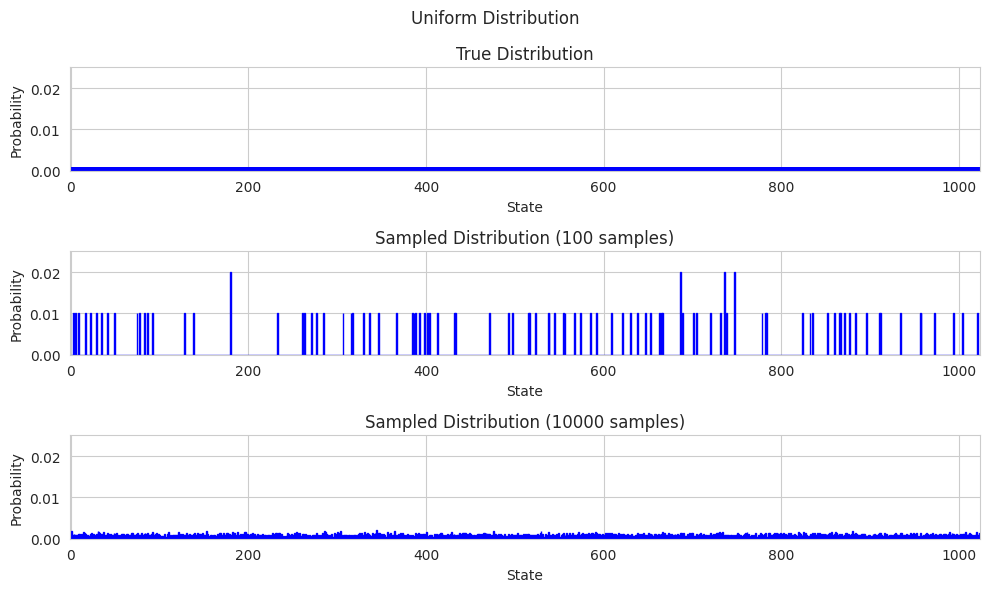

In [ ]:
# insert your code here
rng = np.random.default_rng(0)

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 100 (0.5 pts)
# ------------------------------------
# draw 100 samples from discrete uniform distribution with N states
samples_100 = rng.integers(
    0, N, 100
)  # TODO nachfragen ob integer gewollt, oder floats via rng.uniform()

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 10000 (0.5 pts)
# ------------------------------------
samples_10000 = rng.integers(
    0, N, 10000
)  # TODO nachfragen ob integer gewollt, oder floats via rng.uniform()

# ------------------------------------
# Plot the true distribution and
# the sampled distributions. (0.5 pts)
# ------------------------------------
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

axs[0].bar(np.arange(N), p, linewidth=0, width=1.0, color="b")
axs[0].set_title("True Distribution")

axs[1].hist(samples_100, bins=N, range=(0, N), density=True, ec="b", fc="b")
axs[1].set_title("Sampled Distribution (100 samples)")

axs[2].hist(samples_10000, bins=N, range=(0, N), density=True, ec="b", fc="b")
axs[2].set_title("Sampled Distribution (10000 samples)")

for ax in axs:
    ax.set_xlim(-1, N)
    ax.set_ylim(0, 0.025)
    ax.set_xlabel("State")
    ax.set_ylabel("Probability")

plt.suptitle("Uniform Distribution")
plt.tight_layout()
plt.show()

# TODO hist macht keine schönen plots, aber man sieht mehr, als wenn man np.histogram und bar dann nimmt. Idee wäre bins zusammenzufassen, e.g. immer 8.

##### Observation

For a sample size of 100 the variation and deviation from the true distribution is clearly noticeable. For 10000 samples the distribution approximates the true distribution much better, as it shows less variation.

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [ ]:
sample_sizes = np.round(np.logspace(1, 5, num=10))
n_runs = 1
rng = np.random.default_rng(1)

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sample_sizes), n_runs))
h_mm = np.zeros((len(sample_sizes), n_runs))
h_jk = np.zeros((len(sample_sizes), n_runs))
h_cae = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):

        # ------------------------------------
        # Sample from the uniform distribution
        # with different sample size (0.5 pts)
        # ------------------------------------

        # draw S samples from uniform distribution
        x = rng.integers(
            0, N, size=int(S)
        )  # TODO nachfragen ob integer gewollt, oder floats via rng.uniform()

        # create a histogram using the predefined edges
        counts, _ = np.histogram(x, bins=edges)

        # calculate phat
        phat = counts / np.sum(counts)

        # normalize counts to get phat
        phat = counts / np.sum(counts)

        h_mle[i, j] = entropy_mle(phat)
        h_mm[i, j] = entropy_mm(phat, S)
        h_cae[i, j] = entropy_cae(phat, S)
        # h_jk[i, j] = entropy_jk(x, edges) # TODO einkommentieren, wegen dem läuft das ewig
        h_jvhw[i, j] = entropy_jvhw(x)  # TODO einkommentieren wenn implementiert

(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)


Plot the resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

<matplotlib.legend.Legend>

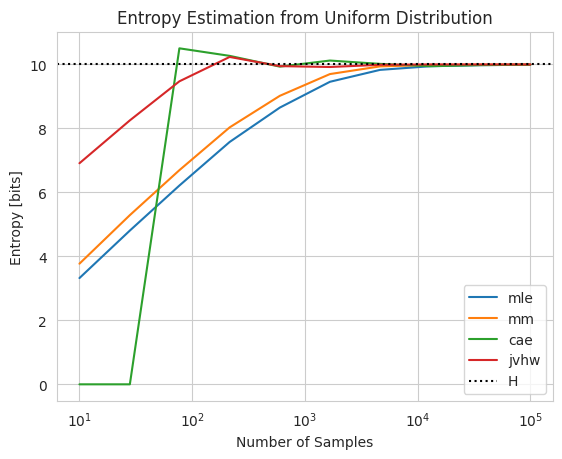

In [ ]:
plt.figure()

plt.semilogx(sample_sizes, np.mean(h_mle, axis=1), label="mle")
plt.semilogx(sample_sizes, np.mean(h_mm, axis=1), label="mm")
plt.semilogx(sample_sizes, np.mean(h_cae, axis=1), label="cae")
# plt.semilogx(sample_sizes, np.mean(h_jk, axis=1), label="jk")
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label="jvhw")

# plot h_unseen or h_bub here if you implemented them.

plt.axhline(H, color="black", linestyle=":", label="H")
plt.xlabel("Number of Samples")
plt.ylabel("Entropy [bits]")
plt.title("Entropy Estimation from Uniform Distribution")
plt.legend()

## Zipf distribution
*Grading: 2 pts*

[Zipf's law ](https://en.wikipedia.org/wiki/Zipf%27s_law) refers to a family of power law like distributions for which $p_k \sim 1/k^d$. We will simply use $d=1$ here.   

Adapt the framework above to sample from a Zipf distribution and evaluate the estimators for this case. Are there differences to the uniform case? (2 pts)

In [ ]:
D = 10
N = 2**D

p = 1 / (np.arange(0, N) + 1)  # true distribution
p = p / np.sum(p)

H = -np.sum(p * np.log2(p))  # true entropy

print(H)

7.510649703297878


Sample from the Zipf distribution using sample sizes of 100 and 10000. In this case, the function `choice` of numpys random number generator is very helpful for sampling. Plot the true distribution and the sampled distributions. What do you notice? 

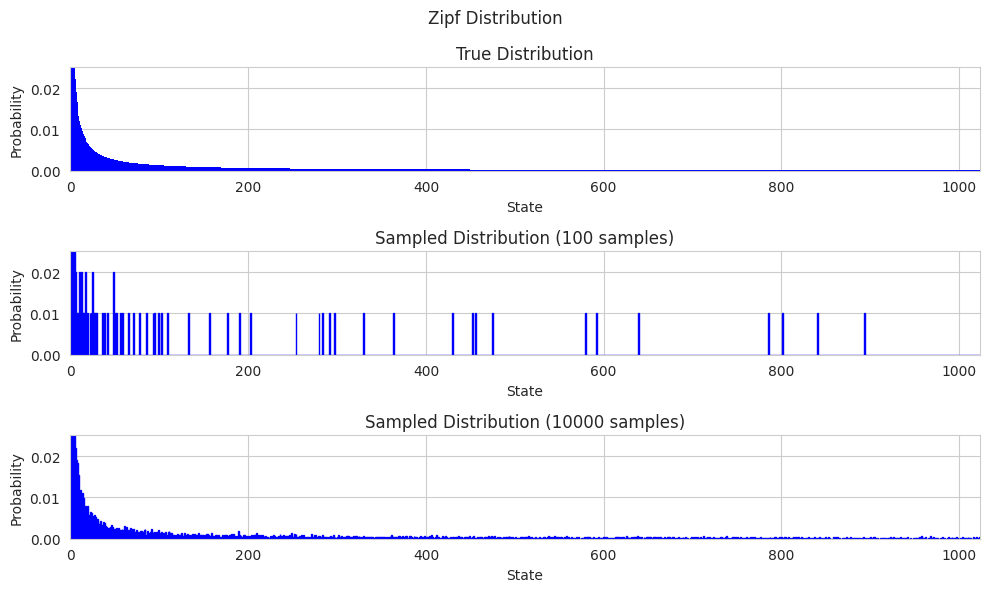

In [ ]:
# insert your code here
rng = np.random.default_rng(2)

# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 100 (0.5 pts)
# ---------------------------------------
samples_100 = rng.choice(np.arange(N), size=100, p=p)

# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 10000 (0.5 pts)
# ---------------------------------------
samples_10000 = rng.choice(np.arange(N), size=10000, p=p)


# ---------------------------------------
# Plot the true distribution and the sampled
# distributions. (0.5 pts)
# ---------------------------------------
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

axs[0].bar(np.arange(N), p, linewidth=0, width=1.0, color="b")
axs[0].set_title("True Distribution")

axs[1].hist(samples_100, bins=N, range=(0, N), density=True, ec="b", fc="b")
axs[1].set_title("Sampled Distribution (100 samples)")

axs[2].hist(samples_10000, bins=N, range=(0, N), density=True, ec="b", fc="b")
axs[2].set_title("Sampled Distribution (10000 samples)")

for ax in axs:
    ax.set_xlim(-1, N)
    ax.set_ylim(0, 0.025)
    ax.set_xlabel("State")
    ax.set_ylabel("Probability")

plt.suptitle("Zipf Distribution")
plt.tight_layout()
plt.show()

# TODO hist macht keine schönen plots, aber man sieht mehr, als wenn man np.histogram und bar dann nimmt. Idee wäre bins zusammenzufassen, e.g. immer 8.

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [ ]:
sample_sizes = np.round(np.logspace(1, 5, num=10))
n_runs = 30
rng = np.random.default_rng(3)

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sample_sizes), n_runs))
h_mm = np.zeros((len(sample_sizes), n_runs))
h_jk = np.zeros((len(sample_sizes), n_runs))
h_cae = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):

        # ---------------------------------------
        # Sample from the Zipf distribution
        # with different sample size (0.5 pts)
        # ---------------------------------------

        # draw S samples from Zipf distribution
        x = rng.choice(np.arange(N), size=int(S), p=p)

        # create a histogram using the predefined edges
        counts, _ = np.histogram(x, bins=edges)

        # calculate phat
        phat = counts / np.sum(counts)

        # normalize counts to get phat
        phat = counts / np.sum(counts)

        h_mle[i, j] = entropy_mle(phat)
        h_mm[i, j] = entropy_mm(phat, S)
        h_cae[i, j] = entropy_cae(phat, S)
        # h_jk[i,j]   = entropy_jk(x, edges) # TODO einkommentieren, wegen dem läuft das ewig
        h_jvhw[i, j] = entropy_jvhw(x)  # TODO einkommentieren wenn implementiert

(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)


Plot resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

<matplotlib.legend.Legend>

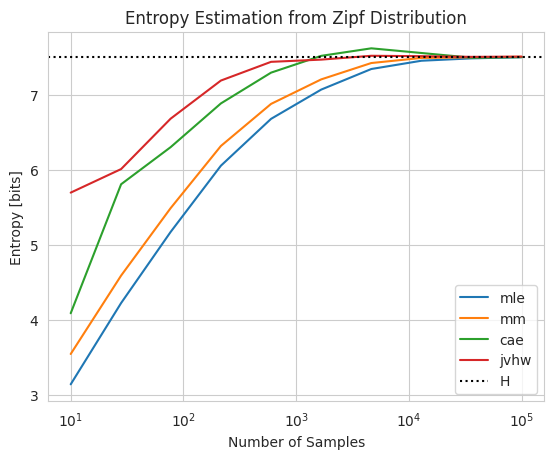

In [ ]:
plt.figure()

plt.semilogx(sample_sizes, np.mean(h_mle, axis=1), label="mle")
plt.semilogx(sample_sizes, np.mean(h_mm, axis=1), label="mm")
plt.semilogx(sample_sizes, np.mean(h_cae, axis=1), label="cae")
# plt.semilogx(sample_sizes, np.mean(h_jk, axis=1), label="jk")
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label="jvhw")

# plot h_unseen or h_bub here if you implemented them.

plt.axhline(H, color="black", linestyle=":", label="H")
plt.xlabel("Number of Samples")
plt.ylabel("Entropy [bits]")
plt.title("Entropy Estimation from Zipf Distribution")
plt.legend()